# LGBM Regressor Baseline

*방향*

 전체 데이터에 대해 제공된 데이터에서 뽑아낼 수 있는 feature만 가지고 진행했을 때 어느 정도 맞는지 확인해 보자.

- train, test set split: cluster 기준 계층적 샘플링.
- 판매량을 넣었을 때, 안 넣었을 때 기준으로 MAPE 측정.

*문제*

- 군집을 반영해줄 수 없다!


*결과*

1. 트리 기반으로 할 수 있는 상품군이 정해져 있는 듯. 농수축 상품군을 대상으로 할 때보다 확 늘어난다.
2. 370000(;;)대 정도가 이 정도 파라미터 조합에서는 수렴하는 MAPE 스코어.
3. 변수 중요도
    - 예상했던 대로 판매단가가 높다.
    - 마더코드, 상품코드 등이 높다. : 구분할 수 있는 것이 필요한가?
    - 방송시간대 중요하다.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import lightgbm as lgb

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
os.getcwd()
os.chdir("/content/drive/My Drive/Big-Contest")
os.getcwd()

'/content/drive/My Drive/Big-Contest'

In [3]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [4]:
# 경로 설정
# RAW_DATA = "./data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx"
RAW_DATA_EXPOSURE_FILLED = "./data/노출시간채운데이터.xlsx"
NSC_CLUSTERED_WITHOUT_OUTLIERS = "./data/농수축_군집4개_이상치제외.csv"
NSC_CLUSTERED_WITH_OUTLIERS = "./data/농수축_군집4개_이상치제외.csv"

In [5]:
# 데이터 로드
data_raw = pd.read_excel(RAW_DATA_EXPOSURE_FILLED, usecols= lambda x: 'Unnamed' not in x)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38309 entries, 0 to 38308
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    38309 non-null  datetime64[ns]
 1   노출(분)   38309 non-null  float64       
 2   마더코드    38309 non-null  int64         
 3   상품코드    38309 non-null  int64         
 4   상품명     38309 non-null  object        
 5   상품군     38309 non-null  object        
 6   판매단가    38309 non-null  int64         
 7   취급액     37372 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.3+ MB


In [6]:
# 무형 제거
data_raw = data_raw[data_raw['상품군'] != '무형']
data_raw.info()
data_raw = data_raw.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37372 entries, 0 to 38303
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    37372 non-null  datetime64[ns]
 1   노출(분)   37372 non-null  float64       
 2   마더코드    37372 non-null  int64         
 3   상품코드    37372 non-null  int64         
 4   상품명     37372 non-null  object        
 5   상품군     37372 non-null  object        
 6   판매단가    37372 non-null  int64         
 7   취급액     37372 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.6+ MB


In [7]:
# 원본 보존
data = data_raw.copy()

In [10]:
# 평가지표 산식
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Feature 선택 1
- 월
- 일
- 요일
- 노출(분)
- ~~마더코드~~
- ~~상품코드~~
- 상품군
- 판매단가


In [11]:
# feature 분리 및 추가
data['월'] = data['방송일시'].dt.month
data['일'] = data['방송일시'].dt.day
data['요일'] = data['방송일시'].dt.dayofweek
day_mapping_dict = {0:'월요일', 1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일', 6:'일요일'}
data['요일'] = data['요일'].map(day_mapping_dict)
data

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,월,일,요일
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,1,1,화요일
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,1,1,화요일
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,1,1,화요일
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,1,1,화요일
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,1,1,화요일
...,...,...,...,...,...,...,...,...,...,...,...
37367,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,12,31,화요일
37368,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,1,1,수요일
37369,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,1,1,수요일
37370,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,1,1,수요일


In [12]:
# 범주형 변수 인코딩
df = data[['월', '일', '요일', '노출(분)', '상품군', '판매단가', '취급액']]
dtypes = df.dtypes

encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info() 

,월,일,요일,노출(분),상품군,판매단가,취급액
0,1,1,6,20.0,6,39900,2099000.0
1,1,1,6,20.0,6,39900,4371000.0
2,1,1,6,20.0,6,39900,3262000.0
3,1,1,6,20.0,6,39900,6955000.0
4,1,1,6,20.0,6,39900,6672000.0
...,...,...,...,...,...,...,...
37367,12,31,6,20.0,9,148000,10157000.0
37368,1,1,2,20.0,9,178000,50929000.0
37369,1,1,2,20.0,9,168000,104392000.0
37370,1,1,2,20.0,9,158000,13765000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   월       37372 non-null  int64  
 1   일       37372 non-null  int64  
 2   요일      37372 non-null  int64  
 3   노출(분)   37372 non-null  float64
 4   상품군     37372 non-null  int64  
 5   판매단가    37372 non-null  int64  
 6   취급액     37372 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 2.0 MB


In [15]:
# 요일 기준 계층적 샘플링
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['요일']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

In [16]:
# 독립변수, 종속변수 분리
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

### 데이터셋 구성

In [17]:
# LGBM 데이터셋 구성
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)

### 파라미터 구성

#### 파라미터 조합 1

In [24]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':10}

In [25]:
model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=1000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 735984
[200]	valid_0's mape: 536650
[300]	valid_0's mape: 448079
[400]	valid_0's mape: 411461
[500]	valid_0's mape: 394120
[600]	valid_0's mape: 385213
[700]	valid_0's mape: 378517
[800]	valid_0's mape: 374006
[900]	valid_0's mape: 370966
[1000]	valid_0's mape: 369282
Did not meet early stopping. Best iteration is:
[983]	valid_0's mape: 369003


#### 파라미터 조합 2


In [ ]:
params = {'learning_rate': 0.001, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':10}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 1.14809e+06
[200]	valid_0's mape: 1.08608e+06
[300]	valid_0's mape: 1.02917e+06
[400]	valid_0's mape: 977022
[500]	valid_0's mape: 929348
[600]	valid_0's mape: 883862
[700]	valid_0's mape: 843590
[800]	valid_0's mape: 805447
[900]	valid_0's mape: 770175
[1000]	valid_0's mape: 738948
[1100]	valid_0's mape: 709750
[1200]	valid_0's mape: 683347
[1300]	valid_0's mape: 659078
[1400]	valid_0's mape: 636407
[1500]	valid_0's mape: 615780
[1600]	valid_0's mape: 596588
[1700]	valid_0's mape: 579156
[1800]	valid_0's mape: 563432
[1900]	valid_0's mape: 548817
[2000]	valid_0's mape: 535719
[2100]	valid_0's mape: 522785
[2200]	valid_0's mape: 510959
[2300]	valid_0's mape: 500574
[2400]	valid_0's mape: 490722
[2500]	valid_0's mape: 481929
[2600]	valid_0's mape: 473918
[2700]	valid_0's mape: 466686
[2800]	valid_0's mape: 459573
[2900]	valid_0's mape: 453402
[3000]	valid_0's mape: 447684
[3100]	valid_0's mape: 442429
[

#### 파라미터 조합 3

In [ ]:
params = {'learning_rate': 0.0025, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5,
          'seed':42,
          'cat_smooth':10}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 1.04654e+06
[200]	valid_0's mape: 912229
[300]	valid_0's mape: 804810
[400]	valid_0's mape: 720138
[500]	valid_0's mape: 652014
[600]	valid_0's mape: 596748
[700]	valid_0's mape: 552645
[800]	valid_0's mape: 517486
[900]	valid_0's mape: 489526
[1000]	valid_0's mape: 467966
[1100]	valid_0's mape: 451360
[1200]	valid_0's mape: 437251
[1300]	valid_0's mape: 426484
[1400]	valid_0's mape: 417794
[1500]	valid_0's mape: 411246
[1600]	valid_0's mape: 404807
[1700]	valid_0's mape: 400832
[1800]	valid_0's mape: 398041
[1900]	valid_0's mape: 394784
[2000]	valid_0's mape: 392369
[2100]	valid_0's mape: 389952
[2200]	valid_0's mape: 387578
[2300]	valid_0's mape: 385377
[2400]	valid_0's mape: 384181
[2500]	valid_0's mape: 383369
[2600]	valid_0's mape: 382140
[2700]	valid_0's mape: 380971
[2800]	valid_0's mape: 379284
[2900]	valid_0's mape: 378612
[3000]	valid_0's mape: 377920
[3100]	valid_0's mape: 377440
[3200]	vali

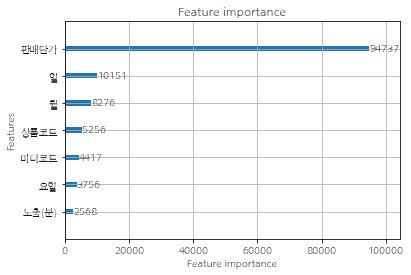

In [ ]:
lgb.plot_importance(model)

## Feature 선택 2
- 월
- 일
- 요일
- 방송시간대
- 노출(분)
- ~~마더코드~~
- ~~상품코드~~
- 판매단가

In [8]:
# feature 분리 및 추가
data['월'] = data['방송일시'].dt.month
data['일'] = data['방송일시'].dt.day
data['요일'] = data['방송일시'].dt.dayofweek
data['방송시간대'] = data['방송일시'].dt.hour
day_mapping_dict = {0:'월요일', 1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일', 6:'일요일'}
data['요일'] = data['요일'].map(day_mapping_dict)
data

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,월,일,요일,방송시간대
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,1,1,화요일,6
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,1,1,화요일,6
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,1,1,화요일,6
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,1,1,화요일,6
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,1,1,화요일,6
...,...,...,...,...,...,...,...,...,...,...,...,...
37367,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,12,31,화요일,23
37368,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,1,1,수요일,0
37369,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,1,1,수요일,0
37370,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,1,1,수요일,0


In [9]:
# 범주형 변수 인코딩
df = data[['월', '일', '요일', '방송시간대', '노출(분)', '상품군', '판매단가', '취급액']]
dtypes = df.dtypes

encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info() 

,월,일,요일,방송시간대,노출(분),상품군,판매단가,취급액
0,1,1,6,6,20.0,6,39900,2099000.0
1,1,1,6,6,20.0,6,39900,4371000.0
2,1,1,6,6,20.0,6,39900,3262000.0
3,1,1,6,6,20.0,6,39900,6955000.0
4,1,1,6,6,20.0,6,39900,6672000.0
...,...,...,...,...,...,...,...,...
37367,12,31,6,23,20.0,9,148000,10157000.0
37368,1,1,2,0,20.0,9,178000,50929000.0
37369,1,1,2,0,20.0,9,168000,104392000.0
37370,1,1,2,0,20.0,9,158000,13765000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   월       37372 non-null  int64  
 1   일       37372 non-null  int64  
 2   요일      37372 non-null  int64  
 3   방송시간대   37372 non-null  int64  
 4   노출(분)   37372 non-null  float64
 5   상품군     37372 non-null  int64  
 6   판매단가    37372 non-null  int64  
 7   취급액     37372 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 2.3 MB


In [10]:
# 요일 기준 계층적 샘플링
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['요일']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

### 데이터셋 구성

In [11]:
# 독립, 종속 분리
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [12]:
# LGBM 데이터셋 구성
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)

### 파라미터 구성

#### 파라미터 조합 1

In [13]:
params = {'learning_rate': 0.001, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 1.14635e+06
[200]	valid_0's mape: 1.08225e+06
[300]	valid_0's mape: 1.02436e+06
[400]	valid_0's mape: 971359
[500]	valid_0's mape: 923080
[600]	valid_0's mape: 878729
[700]	valid_0's mape: 839011
[800]	valid_0's mape: 802153
[900]	valid_0's mape: 769309
[1000]	valid_0's mape: 739522
[1100]	valid_0's mape: 713215
[1200]	valid_0's mape: 689195
[1300]	valid_0's mape: 667177
[1400]	valid_0's mape: 647048
[1500]	valid_0's mape: 628597
[1600]	valid_0's mape: 612466
[1700]	valid_0's mape: 598209
[1800]	valid_0's mape: 584561
[1900]	valid_0's mape: 572297
[2000]	valid_0's mape: 561172
[2100]	valid_0's mape: 550850
[2200]	valid_0's mape: 540857
[2300]	valid_0's mape: 532230
[2400]	valid_0's mape: 524916
[2500]	valid_0's mape: 517707
[2600]	valid_0's mape: 511043
[2700]	valid_0's mape: 504829
[2800]	valid_0's mape: 499265
[2900]	valid_0's mape: 494185
[3000]	valid_0's mape: 489466
[3100]	valid_0's mape: 484837
[

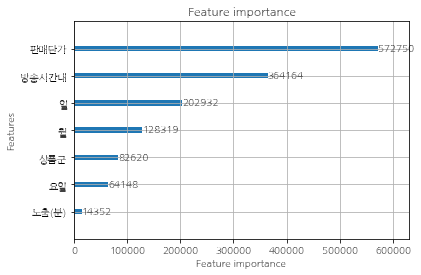

In [14]:
lgb.plot_importance(model)

#### 파라미터 조합 2

In [15]:
params = {'learning_rate': 0.001, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}

model = lgb.train(params=params, b
                  train_set=ds_train,
                  num_boost_round=100000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 1.1485e+06
[200]	valid_0's mape: 1.08583e+06
[300]	valid_0's mape: 1.03027e+06
[400]	valid_0's mape: 979770
[500]	valid_0's mape: 933095
[600]	valid_0's mape: 889736
[700]	valid_0's mape: 850615
[800]	valid_0's mape: 814276
[900]	valid_0's mape: 781301
[1000]	valid_0's mape: 752252
[1100]	valid_0's mape: 725795
[1200]	valid_0's mape: 700992
[1300]	valid_0's mape: 678620
[1400]	valid_0's mape: 658359
[1500]	valid_0's mape: 639562
[1600]	valid_0's mape: 622656
[1700]	valid_0's mape: 607753
[1800]	valid_0's mape: 593657
[1900]	valid_0's mape: 580434
[2000]	valid_0's mape: 568928
[2100]	valid_0's mape: 557579
[2200]	valid_0's mape: 547466
[2300]	valid_0's mape: 538690
[2400]	valid_0's mape: 530626
[2500]	valid_0's mape: 523015
[2600]	valid_0's mape: 516107
[2700]	valid_0's mape: 509769
[2800]	valid_0's mape: 503702
[2900]	valid_0's mape: 498399
[3000]	valid_0's mape: 493217
[3100]	valid_0's mape: 489113
[3

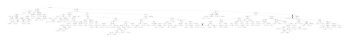

In [16]:
lgb.plot_tree(model)

#### 파라미터 조합 3

In [18]:
params = {'learning_rate': 0.025, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':15}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 612788
[200]	valid_0's mape: 525502
[300]	valid_0's mape: 484447
[400]	valid_0's mape: 471368
[500]	valid_0's mape: 458734
[600]	valid_0's mape: 451993
[700]	valid_0's mape: 443083
[800]	valid_0's mape: 435214
[900]	valid_0's mape: 431519
[1000]	valid_0's mape: 425396
[1100]	valid_0's mape: 421251
[1200]	valid_0's mape: 416738
[1300]	valid_0's mape: 412844
[1400]	valid_0's mape: 407695
[1500]	valid_0's mape: 404023
[1600]	valid_0's mape: 400289
[1700]	valid_0's mape: 396709
[1800]	valid_0's mape: 394914
[1900]	valid_0's mape: 391974
[2000]	valid_0's mape: 391648
[2100]	valid_0's mape: 391850
Early stopping, best iteration is:
[2040]	valid_0's mape: 390515


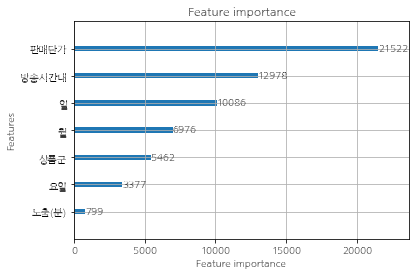

In [19]:
lgb.plot_importance(model)

## Feature 선택 3
- 월
- 일
- 요일
- 방송시간대
- 노출(분)
- 마더코드
- ~~상품코드~~
- 판매단가

In [20]:
# feature 선택 및 범주형 변수 인코딩
df = data[['월', '일', '요일', '방송시간대', '노출(분)', '상품군', '마더코드', '판매단가', '취급액']]
dtypes = df.dtypes

encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info() 

,월,일,요일,방송시간대,노출(분),상품군,마더코드,판매단가,취급액
0,1,1,6,6,20.0,6,100346,39900,2099000.0
1,1,1,6,6,20.0,6,100346,39900,4371000.0
2,1,1,6,6,20.0,6,100346,39900,3262000.0
3,1,1,6,6,20.0,6,100346,39900,6955000.0
4,1,1,6,6,20.0,6,100346,39900,6672000.0
...,...,...,...,...,...,...,...,...,...
37367,12,31,6,23,20.0,9,100448,148000,10157000.0
37368,1,1,2,0,20.0,9,100448,178000,50929000.0
37369,1,1,2,0,20.0,9,100448,168000,104392000.0
37370,1,1,2,0,20.0,9,100448,158000,13765000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   월       37372 non-null  int64  
 1   일       37372 non-null  int64  
 2   요일      37372 non-null  int64  
 3   방송시간대   37372 non-null  int64  
 4   노출(분)   37372 non-null  float64
 5   상품군     37372 non-null  int64  
 6   마더코드    37372 non-null  int64  
 7   판매단가    37372 non-null  int64  
 8   취급액     37372 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 2.6 MB


In [21]:
# 요일 기준 계층적 샘플링
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['요일']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

### 데이터셋 구성

In [22]:
# 독립, 종속 분리
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [23]:
# LGBM 데이터셋 구성
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)

### 파라미터 구성

#### 파라미터 조합1

In [25]:
params = {'learning_rate': 0.001, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}

model = lgb.train(params=params,
                  train_set=ds_train,
                  num_boost_round=100000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 1.14498e+06
[200]	valid_0's mape: 1.08032e+06
[300]	valid_0's mape: 1.02105e+06
[400]	valid_0's mape: 967818
[500]	valid_0's mape: 919034
[600]	valid_0's mape: 875063
[700]	valid_0's mape: 834687
[800]	valid_0's mape: 798483
[900]	valid_0's mape: 765622
[1000]	valid_0's mape: 736186
[1100]	valid_0's mape: 709400
[1200]	valid_0's mape: 684632
[1300]	valid_0's mape: 662550
[1400]	valid_0's mape: 642447
[1500]	valid_0's mape: 624394
[1600]	valid_0's mape: 607817
[1700]	valid_0's mape: 592746
[1800]	valid_0's mape: 579080
[1900]	valid_0's mape: 566703
[2000]	valid_0's mape: 555625
[2100]	valid_0's mape: 544752
[2200]	valid_0's mape: 535109
[2300]	valid_0's mape: 526006
[2400]	valid_0's mape: 517992
[2500]	valid_0's mape: 510715
[2600]	valid_0's mape: 503519
[2700]	valid_0's mape: 497208
[2800]	valid_0's mape: 490948
[2900]	valid_0's mape: 485441
[3000]	valid_0's mape: 480439
[3100]	valid_0's mape: 475932
[

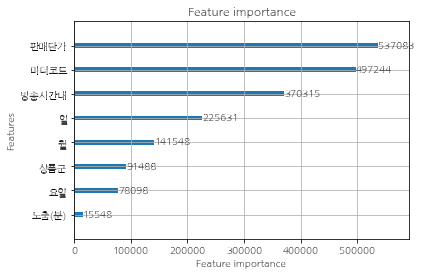

In [26]:
# 변수 중요도
lgb.plot_importance(model)

## Feature 선택 4
- 월
- 일
- 요일
- 방송시간대
- 노출(분)
- 마더코드
- 상품코드
- 판매단가

In [27]:
# feature 선택 및 범주형 변수 인코딩
df = data[['월', '일', '요일', '방송시간대', '노출(분)', '상품군', '마더코드', '상품코드', '판매단가', '취급액']]
dtypes = df.dtypes

encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info() 

,월,일,요일,방송시간대,노출(분),상품군,마더코드,상품코드,판매단가,취급액
0,1,1,6,6,20.0,6,100346,201072,39900,2099000.0
1,1,1,6,6,20.0,6,100346,201079,39900,4371000.0
2,1,1,6,6,20.0,6,100346,201072,39900,3262000.0
3,1,1,6,6,20.0,6,100346,201079,39900,6955000.0
4,1,1,6,6,20.0,6,100346,201072,39900,6672000.0
...,...,...,...,...,...,...,...,...,...,...
37367,12,31,6,23,20.0,9,100448,201391,148000,10157000.0
37368,1,1,2,0,20.0,9,100448,201383,178000,50929000.0
37369,1,1,2,0,20.0,9,100448,201390,168000,104392000.0
37370,1,1,2,0,20.0,9,100448,201384,158000,13765000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   월       37372 non-null  int64  
 1   일       37372 non-null  int64  
 2   요일      37372 non-null  int64  
 3   방송시간대   37372 non-null  int64  
 4   노출(분)   37372 non-null  float64
 5   상품군     37372 non-null  int64  
 6   마더코드    37372 non-null  int64  
 7   상품코드    37372 non-null  int64  
 8   판매단가    37372 non-null  int64  
 9   취급액     37372 non-null  float64
dtypes: float64(2), int64(8)
memory usage: 2.9 MB


In [28]:
# 요일 기준 계층적 샘플링
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['요일']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

### 데이터셋 구성

In [29]:
# 독립, 종속 분리
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [30]:
# LGBM 데이터셋 구성
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)

### 파라미터 구성

#### 파라미터 조합1

In [31]:
params = {'learning_rate': 0.001, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}

model = lgb.train(params=params,
                  train_set=ds_train,
                  num_boost_round=100000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 1.14382e+06
[200]	valid_0's mape: 1.07742e+06
[300]	valid_0's mape: 1.01731e+06
[400]	valid_0's mape: 962951
[500]	valid_0's mape: 914357
[600]	valid_0's mape: 870042
[700]	valid_0's mape: 829483
[800]	valid_0's mape: 793293
[900]	valid_0's mape: 760405
[1000]	valid_0's mape: 730508
[1100]	valid_0's mape: 703729
[1200]	valid_0's mape: 679048
[1300]	valid_0's mape: 657095
[1400]	valid_0's mape: 636453
[1500]	valid_0's mape: 618143
[1600]	valid_0's mape: 601405
[1700]	valid_0's mape: 586321
[1800]	valid_0's mape: 572533
[1900]	valid_0's mape: 559984
[2000]	valid_0's mape: 548686
[2100]	valid_0's mape: 537733
[2200]	valid_0's mape: 528112
[2300]	valid_0's mape: 518874
[2400]	valid_0's mape: 511076
[2500]	valid_0's mape: 503485
[2600]	valid_0's mape: 496487
[2700]	valid_0's mape: 490505
[2800]	valid_0's mape: 484343
[2900]	valid_0's mape: 479031
[3000]	valid_0's mape: 474175
[3100]	valid_0's mape: 469543
[

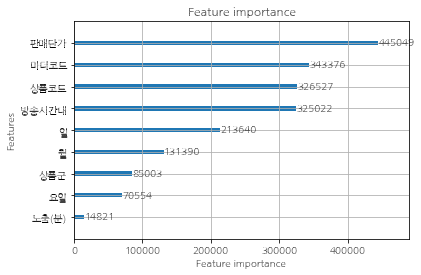

In [32]:
# 변수 중요도
lgb.plot_importance(model)